In [1]:
import os 
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model

# === CONFIG ===
DATA_DIR = './dataset_2'
TEST_DIR = './test'
IMG_SIZE = (128, 128)
BATCH_SIZE = 32
AUTOTUNE = tf.data.AUTOTUNE
EPOCHS = 10


In [2]:
train_ds = image_dataset_from_directory(
    DATA_DIR,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode="int"
)

val_ds = image_dataset_from_directory(
    DATA_DIR,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode="int"
)

test_ds = image_dataset_from_directory(
    TEST_DIR,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode="int"
)

class_names = train_ds.class_names
NUM_CLASSES = len(class_names)
print("Classes:", class_names)


Found 480 files belonging to 4 classes.
Using 384 files for training.
Found 480 files belonging to 4 classes.
Using 96 files for validation.
Found 480 files belonging to 4 classes.
Classes: ['glioma', 'meningioma', 'notumor', 'pituitary']


In [3]:
def normalize(image, label):
    image = tf.cast(image, tf.float32) / 255.0
    return image, label

train_ds = train_ds.map(normalize).cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.map(normalize).cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.map(normalize).cache().prefetch(buffer_size=AUTOTUNE)


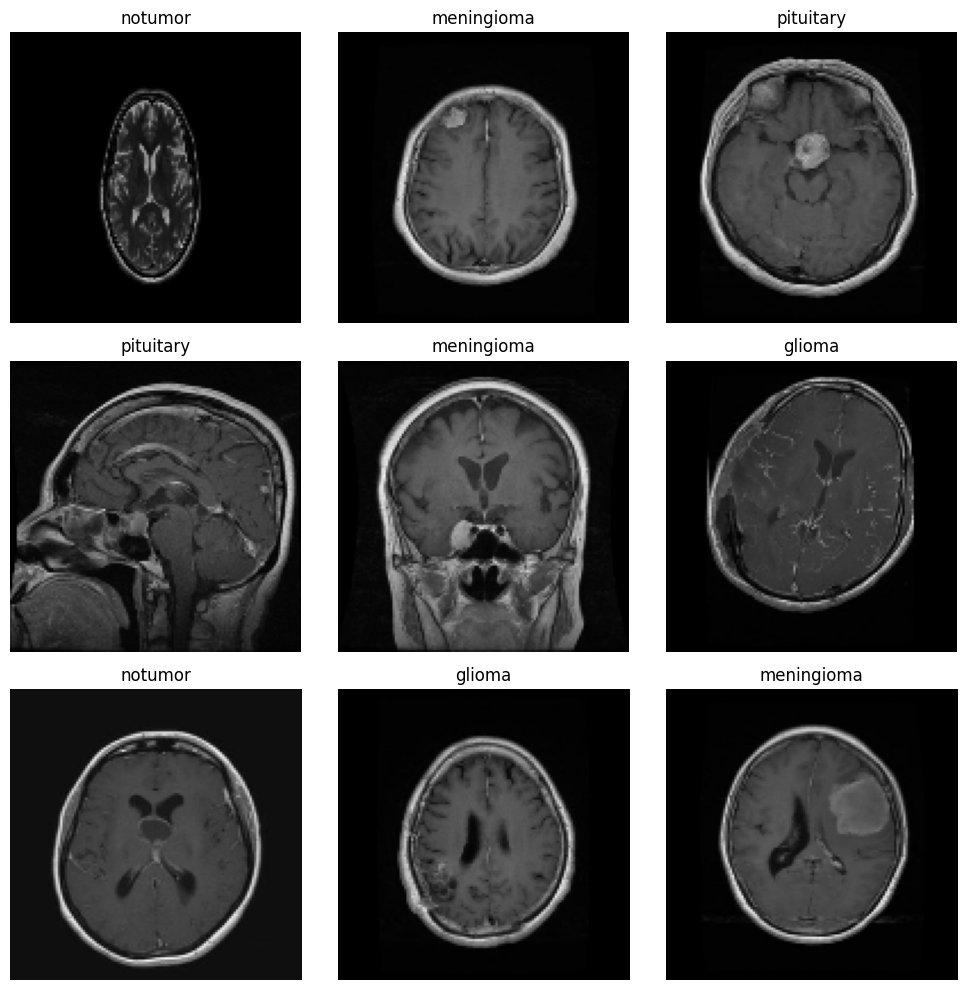

In [4]:
def plot_images(dataset):
    plt.figure(figsize=(10, 10))
    for images, labels in dataset.take(1):
        for i in range(9):
            ax = plt.subplot(3, 3, i + 1)
            plt.imshow(images[i].numpy())
            plt.title(class_names[labels[i]])
            plt.axis("off")
    plt.tight_layout()
    plt.show()

plot_images(train_ds)


In [5]:
def transfer_model():
    base_model = MobileNetV2(input_shape=(*IMG_SIZE, 3), include_top=False, weights='imagenet')
    base_model.trainable = False

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.3)(x)
    outputs = Dense(NUM_CLASSES, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=outputs)
    return model

model = transfer_model()
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 64, 64,    │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 64, 64,    │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 64, 64,    │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 64, 64,    │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 64, 64,    │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 64, 64,    │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 64, 64,    │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 64, 64,    │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 64, 64,    │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 64, 64,    │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 64, 64,    │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 65, 65,    │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 32, 32,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 32, 32,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 32, 32,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 32, 32,    │      2,304 │ block_1_depthwis

 Total params: 2,263,108 (8.63 MB)

 Trainable params: 5,124 (20.02 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [6]:
def compile_and_train(model):
    model.compile(
        optimizer='adam',
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
        metrics=['accuracy']
    )
    history = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=EPOCHS
    )
    return history

history = compile_and_train(model)


Epoch 1/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 22s 731ms/step - accuracy: 0.3072 - loss: 1.5937 - val_accuracy: 0.5938 - val_loss: 1.0624
Epoch 2/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 279ms/step - accuracy: 0.5320 - loss: 1.1315 - val_accuracy: 0.6458 - val_loss: 0.8717
Epoch 3/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 283ms/step - accuracy: 0.6307 - loss: 0.9199 - val_accuracy: 0.7500 - val_loss: 0.6971
Epoch 4/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 274ms/step - accuracy: 0.6984 - loss: 0.7960 - val_accuracy: 0.7500 - val_loss: 0.6286
Epoch 5/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 282ms/step - accuracy: 0.7583 - loss: 0.6052 - val_accuracy: 0.8125 - val_loss: 0.5390
Epoch 6/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 276ms/step - accuracy: 0.8361 - loss: 0.4799 - val_accuracy: 0.8125 - val_loss: 0.5207
Epoch 7/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 265ms/step - accuracy: 0.8249 - loss: 0.4930 - val_accuracy: 0.8333 - val_loss: 0.4839
Epoch 8/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 293ms/step - accuracy: 0.8720 - loss: 0.4214 - val_accuracy: 0

In [7]:
def evaluate_model(model, dataset, name="Validation"):
    loss, acc = model.evaluate(dataset)
    print(f"{name} Loss: {loss:.4f}, {name} Accuracy: {acc:.4f}")

    y_true = []
    y_pred = []

    for images, labels in dataset:
        preds = model.predict(images)
        y_pred.extend(np.argmax(preds, axis=1))
        y_true.extend(labels.numpy())

    print(f"\n{name} Classification Report:")
    print(classification_report(y_true, y_pred, target_names=class_names))

    print(f"\n{name} Confusion Matrix:")
    print(confusion_matrix(y_true, y_pred))

evaluate_model(model, val_ds, name="Validation")


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 233ms/step - accuracy: 0.8828 - loss: 0.3751
Validation Loss: 0.4416, Validation Accuracy: 0.8438
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 352ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 281ms/step

Validation Classification Report:
              precision    recall  f1-score   support

      glioma       1.00      0.85      0.92        26
  meningioma       0.75      0.75      0.75        20
     notumor       0.91      0.84      0.88        25
   pituitary       0.74      0.92      0.82        25

    accuracy                           0.84        96
   macro avg       0.85      0.84      0.84        96
weighted avg       0.86      0.84      0.85        96


Validation Confusion Matrix:
[[22  3  0  1]
 [ 0 15  2  3]
 [ 0  0 21  4]
 [ 0  2  0 23]]


In [8]:
evaluate_model(model, test_ds, name="Test")


15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 293ms/step - accuracy: 0.8411 - loss: 0.4490
Test Loss: 0.4434, Test Accuracy: 0.8333
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 431ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 318ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 312ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 303ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 341ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 315ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 358ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 326ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 311ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 319ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 295ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 329ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 329ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 307ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 340ms/step

Test Classification Report:
              precision    recall  f1-score   support

      glioma       0.85      0.88      0.86       120
  meningioma       0.75      0.69      0.72       120
     notumor       0.85      0.87      0.86       120
   pituitary       0.87      0.90      0.89       120